In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder

target_col = "label"  # "status"
ok_val = 1  # "OK"


df = pd.read_csv("train.csv")
to_drop = ["physical_part_id", "message_timestamp"]
for c in df.columns:
    if df[c].isna().all():
        to_drop.append(c)
df = df.drop(columns=to_drop)
target = df[target_col] == ok_val
df = df.drop(columns=[target_col])
categorical_features = [c for c in df.columns if "sensor" not in c]
df = pd.get_dummies(df, columns=categorical_features)
df.head()


,s6_sensor0_millimeter_step1,s8_sensor0_millimeter_step1,s8_sensor1_millimeter_step1,s7_sensor0_newton_step1,s9_sensor0_kilonewton_step1,s7_sensor1_mikrometer_step1,s0_sensor0_kilonewton_step3,s2_sensor0_millimeter_step1,s9_sensor1_sekunden (zeit)_step1,s8_sensor2_millimeter_step1,...,physical_part_type_type4,weekday_Friday,weekday_Monday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,shift_Fruehschicht,shift_Nachtschicht,shift_Spaetschicht
0,4606.469076,20.936714,390.550800,8856.466834,36.836737,32226.284706,NaN,19.696395,1056.249745,7.556479,...,False,False,False,False,False,True,False,True,False,False
1,4606.469076,18.293964,378.279734,8860.946584,36.836737,32700.200657,NaN,17.763653,1056.249745,7.119582,...,False,True,False,False,False,False,False,True,False,False
2,5886.043819,20.944510,428.742769,8849.747208,36.836737,32429.391542,-53.537243,19.582187,1056.249745,9.377910,...,False,False,False,False,False,True,False,True,False,False
3,4606.469076,18.475864,373.095553,8845.267457,36.836737,32564.796100,NaN,18.238053,1056.249745,7.541095,...,False,False,False,False,True,False,False,True,False,False
4,4606.469076,19.801137,382.829679,8847.507333,36.836737,33309.521166,NaN,19.178068,1013.999755,8.282590,...,False,False,True,False,False,False,False,False,False,True


In [4]:
df_train = df.sample(frac=0.9, random_state=42)
df_val = df.drop(df_train.index)
target_train = target.iloc[df_train.index]
target_val = target.iloc[df_val.index]


In [13]:
# Impute all NaNs in df_train with mean, then use the same imputation for df_val
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(df_train)
y_train = target_train.values.reshape(-1, 1)
X_val = imputer.transform(df_val)
y_val = target_val.values.reshape(-1, 1)


In [14]:
import torch
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier


In [15]:
clf = TabNetMultiTaskClassifier(
    n_steps=17,
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    # cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={
        "step_size": 50,  # how to use learning rate scheduler
        "gamma": 0.9,
    },
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",  # "sparsemax",
    lambda_sparse=0,  # don't penalize for sparser attention
)


/Users/mike/.pyenv/versions/3.10.14/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [17]:
max_epochs = 1000
clf.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_val, y_val)],
    max_epochs=max_epochs,
    patience=3,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)


epoch 0  | loss: 9.8064  | val_0_logloss: 14.85163|  0:00:19s
epoch 1  | loss: 5.70943 | val_0_logloss: 7.70499 |  0:00:39s
epoch 2  | loss: 0.34415 | val_0_logloss: 0.90106 |  0:00:58s
epoch 3  | loss: 0.26959 | val_0_logloss: 0.90106 |  0:01:18s
epoch 4  | loss: 0.21644 | val_0_logloss: 0.90106 |  0:01:37s
epoch 5  | loss: 0.21729 | val_0_logloss: 0.90106 |  0:01:56s

Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_logloss = 0.90106


/Users/mike/.pyenv/versions/3.10.14/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


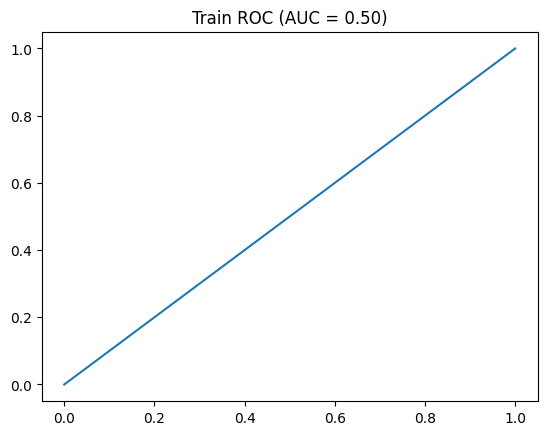

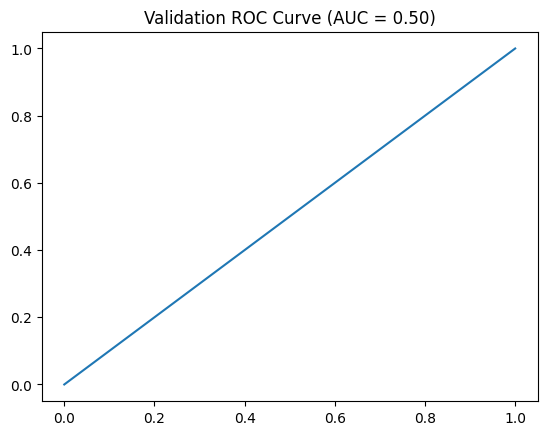

In [24]:
# Plot ROC curve on train
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

y_pred = clf.predict_proba(X_train)[0][:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Train ROC (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()

y_pred = clf.predict_proba(X_val)[0][:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Validation ROC Curve (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()
